In [71]:
#Preliminaries
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
import math
from sklearn.utils import resample
from scipy import percentile
from scipy import stats
from matplotlib import pyplot as plt
import requests
import io
import seaborn as sns
from matplotlib.patches import Rectangle
sns.set()

In [72]:
# Create function to calculate the lag selection parameter for the standard HAC Newey-West
# (1994) plug-in procedure
def mLag(no_obs):
    result = math.floor(math.pow(4*no_obs/100,(2/9)))
    return result

# Set up regression function with Newey-West Standard Errors (HAC)
def ols(dependent_var, regressors, no_obs):
    result = sm.OLS(endog=dependent_var, exog=regressors, missing='drop').\
                fit(cov_type='HAC',cov_kwds={'maxlags':mLag(no_obs)+1})
    return result

# Set up regression function with Newey-West Standard Errors (HAC)
def ols_s(left_side, right_side, maxLag_temp):
    result = sm.OLS(left_side, right_side, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':maxLag_temp})
    return result

def ecdf(sample):
    sample = np.atleast_1d(sample)
    quantiles, counts = np.unique(sample, return_counts=True)
    cumprob = np.cumsum(counts).astype(np.double) / sample.size
    return quantiles, cumprob

### Load Data

In [73]:
# Dataset is local, not on github
Y_raw = pd.read_csv('../data/global_funds.csv',parse_dates=['Dates'],index_col=['Dates'])
X_raw = pd.read_csv('../data/global_factors.csv',parse_dates=['Dates'],index_col=['Dates'])
    
Y_raw.shape,X_raw.shape


((240, 193), (240, 4))

In [74]:
# Create lists of Fama-French factors and mutual fund symbols
min_number_of_obs = 120
Y_all = Y_raw.loc[:, (Y_raw.count().values > min_number_of_obs)] # discard funds with too many missing values
Y_all = Y_all.sub(X_raw['RF'],axis=0) # subtract RF from fund returns
funds = Y_all.columns.get_values().tolist() # list with names of funds
factors = X_raw.columns.get_values().tolist() # list with names of global factors

# remove RF since we already differenced it in Y
factors_remove = ['RF'] # remove these factors from list of factors
for items in factors_remove:
    factors.remove(items)

Y_all.shape, len(factors)

((240, 125), 3)

In [75]:
# create matrix of regressors for regression analysis
X_mat=X_raw[factors].copy()
X_mat.insert(0, 'const', float(1)) # insert column of ones for the constant in regression
X_mat.rename({'WLRF':'Mkt-RF'},axis='columns',inplace=True)

# Data Type and Shape information
X_mat.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 1999-01-31 to 2018-12-31
Data columns (total 4 columns):
const     240 non-null float64
Mkt-RF    240 non-null float64
SMB       240 non-null float64
HML       240 non-null float64
dtypes: float64(4)
memory usage: 9.4 KB


## 1. Constructing matrix of dependent variables (fund returns) and explanatory variables (factor returns)

In [76]:
# Parameters of Simulations
np.random.seed(2) 
n_obs = X_mat.shape[0]  # number of observations
n_funds = Y_all.shape[1]  # number of funds with return series
n_factors = X_mat.shape[1]-1 # risk factors
n_simulations = 1000 # number of simulations

# Variable Names
factor_names=['Alpha','Mkt-RF','SMB','HML']
sim_factors=['Mkt-RF', 'SMB', 'HML']
one_name=['Alpha']

# Empty coefficient and standard error matrices (fill with results later)
orig_coeffs = pd.DataFrame(np.zeros(shape = (n_factors+1, n_funds)), index=factor_names, columns = funds)/0
orig_SE_coeffs = pd.DataFrame(np.zeros(shape = (n_factors+1, n_funds)), index=factor_names, columns = funds)/0


## 2. Perform initial regressions on actual fund returns

In [77]:
# Calculate number of observations per fund per simulation for future
# reference:
n_i = (~np.isnan(Y_all)).sum(axis=0) # number of observations of each fund in data

# Test ols function
test_fund = 0
y_sample = Y_all.iloc[:,test_fund]         # y_sample is just one column of Y_all
lm = ols(y_sample, X_mat, n_i.iloc[test_fund]) 

# Check Sample Regression Results
for name,result in zip(['coefficients','standard errors','# observations'],
                       [lm.params, lm.bse, lm.nobs]):
    print(name)
    print("-"*len(name))
    print(result,"\n")

coefficients
------------
const     0.154505
Mkt-RF    0.928434
SMB      -0.006721
HML       0.127987
dtype: float64 

standard errors
---------------
const     0.067194
Mkt-RF    0.016006
SMB       0.047993
HML       0.048858
dtype: float64 

# observations
--------------
240.0 



In [78]:
#Perform initial regressions on fund returns
for fund in range(n_funds):
    y_sample = Y_all.iloc[:,fund] # choose fund
    lm = ols(y_sample,X_mat, n_i[fund]) # run OLS
    
    for factor in range(n_factors+1):   
        orig_coeffs.iloc[factor, fund] = lm.params.iloc[factor]
        orig_SE_coeffs.iloc[factor, fund] = lm.bse.iloc[factor]

### TODO
Checkout a plotly representation of the coefficient and standard error data. Possibly four histograms.

In [79]:
# Regression coefficient dataframe preview
print(orig_coeffs.info())
orig_coeffs.T.Alpha.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, Alpha to HML
Columns: 125 entries, CWIAX to WIMVX
dtypes: float64(125)
memory usage: 3.9+ KB
None


CWIAX    0.154505
CNPAX    0.218319
TEDIX    0.233386
VTWSX   -0.046309
OWLSX   -0.148419
Name: Alpha, dtype: float64

In [80]:
# Coefficient Standard Error preview
orig_SE_coeffs.info()
orig_SE_coeffs.T.Alpha.head()

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, Alpha to HML
Columns: 125 entries, CWIAX to WIMVX
dtypes: float64(125)
memory usage: 3.9+ KB


CWIAX    0.067194
CNPAX    0.064061
TEDIX    0.099452
VTWSX    0.036009
OWLSX    0.103827
Name: Alpha, dtype: float64

Added this chart, to help visualize alphas and standard errors

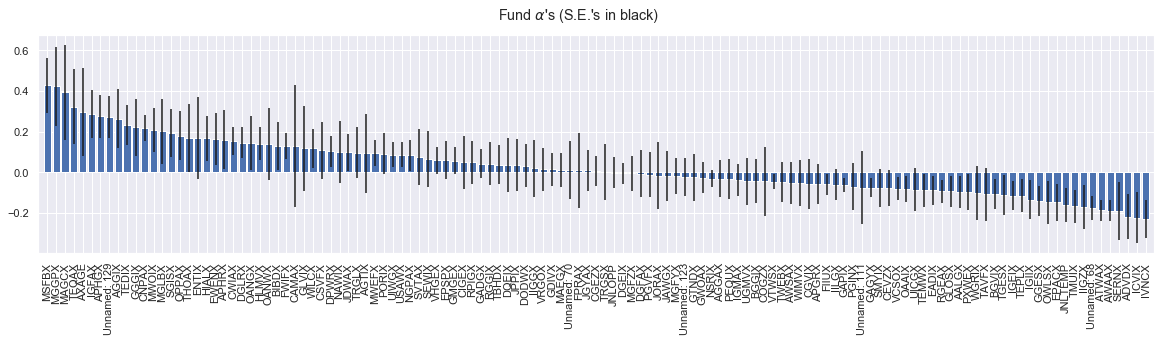

In [81]:
# sort by alpha (descending order)
funds_by_alpha = np.argsort(orig_coeffs.iloc[0,:])[::-1] 

# Bar Chart
plt.figure(figsize=(20,4))
plt.bar(x=range(n_funds),
        height=orig_coeffs.iloc[0,:][funds_by_alpha],
        tick_label=orig_coeffs.columns[funds_by_alpha],
        yerr=orig_SE_coeffs.iloc[0,:][funds_by_alpha])
plt.xticks(rotation=90)
plt.xlim((-1,n_funds))
plt.suptitle(r"Fund $\alpha$'s (S.E.'s in black)")

plt.show()

In [82]:
# rename all coefficients with t(.)
rename_dict = {}
for coeff in orig_coeffs.index:
    rename_dict[coeff] = 't({})'.format(coeff) 

# Calculate t-statistics with nans creating other nans (fill_value=None)
orig_t_stats = orig_coeffs.divide(orig_SE_coeffs, axis='columns', fill_value=None).rename(rename_dict,axis='index')
orig_t_stats

,CWIAX,CNPAX,TEDIX,VTWSX,OWLSX,TEPLX,OPPAX,DODWX,DGEIX,VHGEX,...,CGVIX,CAMAX,IGEIX,COGZX,BGVIX,ENTIX,GGESX,APGRX,TRGSX,WIMVX
t(Alpha),2.299372,3.407998,2.346720,-1.286024,-1.429483,-1.433317,1.516646,0.307831,-0.092684,0.855138,...,-0.467519,0.426026,-1.643792,-0.267552,-1.453064,0.843345,-1.887231,-0.597369,0.016179,-0.477360
t(Mkt-RF),58.006242,57.385411,16.040320,86.071662,23.118600,47.816327,50.164448,33.579313,56.576723,52.540700,...,24.968206,15.572290,45.918663,24.960339,34.931681,17.129575,43.434728,40.258584,20.124354,31.588523
t(SMB),-0.140036,-1.220435,1.166670,-2.626950,1.962605,-1.965159,2.486946,-0.597266,2.088864,1.345255,...,0.144403,1.074823,-5.877479,0.621983,-2.341202,2.008583,-2.347630,2.379146,0.567885,-4.845417
t(HML),2.619575,-2.100086,3.063157,-0.541205,1.781287,7.732469,-1.211126,5.890446,3.068588,6.513494,...,4.299664,1.828101,5.955161,-5.585127,6.292898,-1.374715,4.434818,-5.302437,-6.923101,1.366821


In [83]:
# Calculated predictions, residuals, and sum of squared residuals (SSR) 
# and standard errors (SE )from X inputs and orig_coeffs
Y_pred = np.dot(X_mat.values,orig_coeffs.values) # fitted values
orig_resids = Y_all.values - Y_pred              # residuals
orig_SSR = np.nansum(orig_resids**2,0)           # sum squared residuals
orig_SE_resid = np.divide(orig_SSR**.5, (n_i-n_factors)) # standard errors

# 
print(orig_SE_resid.shape)
orig_SE_resid.head()

(125,)


CWIAX    0.063785
CNPAX    0.061459
TEDIX    0.086532
VTWSX    0.042760
OWLSX    0.089743
dtype: float64

In [84]:
# Rank funds by alpha
rank_a = orig_coeffs.transpose(copy=True)
rank_a['Rank_a'] = rank_a['Alpha'].rank(ascending=False)
orig_coeffs_rank_a = rank_a.sort_values(by='Alpha', axis=0, ascending=False)

# Print Previews
print("Ten Most Positive Alphas")
print(orig_coeffs_rank_a.head(10),"\n")
print("Ten Most Negative Alphas")
print(orig_coeffs_rank_a.tail(10))

Ten Most Positive Alphas
                 Alpha    Mkt-RF       SMB       HML  Rank_a
MSFBX         0.427591  0.714611 -0.266890  0.038603     1.0
MGGPX         0.423748  1.150749  0.302729 -0.573910     2.0
MAGCX         0.392557  1.039371  0.750257 -0.230193     3.0
TEQAX         0.321823  0.920811  0.251732 -0.751767     4.0
AXAGE         0.296094  1.239881  0.350411 -0.266739     5.0
IGFAX         0.287707  0.730322 -0.333441 -0.107715     6.0
APHGX         0.274649  0.868930 -0.247148  0.201847     7.0
Unnamed: 129  0.270221  1.001486  0.136358 -0.394302     8.0
AGGIX         0.263983  0.989996  0.200862 -0.345853     9.0
TEDIX         0.233386  0.635116  0.063753  0.178474    10.0 

Ten Most Negative Alphas
                Alpha    Mkt-RF       SMB       HML  Rank_a
JNLTEMP     -0.161314  1.020641 -0.153533  0.280705   116.0
TMUIX       -0.167947  1.091462  0.062179 -0.177965   117.0
IIGZX       -0.170155  1.025652 -0.343237  0.147015   118.0
Unnamed: 68 -0.174744  0.976101 -0.17

In [85]:
#Rank funds by t(alpha)
rank_t = orig_t_stats.transpose(copy=True)
rank_t['Rank_t'] = rank_t['t(Alpha)'].rank(ascending=False)
orig_coeffs_rank_t = rank_t.sort_values(by='t(Alpha)', axis=0, ascending=False)

# Print Previews
print("Ten Most Significant Positive Alphas")
print(orig_coeffs_rank_t.head(10),"\n")
print("Ten Most Significant Negative Alphas")
print(orig_coeffs_rank_t.tail(10))


Ten Most Significant Positive Alphas
              t(Alpha)  t(Mkt-RF)    t(SMB)    t(HML)  Rank_t
CNPAX         3.407998  57.385411 -1.220435 -2.100086     1.0
MSFBX         3.149317  18.404386 -2.043943  0.271595     2.0
Unnamed: 129  2.634869  46.619731  1.758379 -5.178336     3.0
APHGX         2.596955  31.674597 -3.150700  3.167546     4.0
IGFAX         2.417043  17.852991 -2.598018 -0.921890     5.0
TEDIX         2.346720  16.040320  1.166670  3.063157     6.0
CWIAX         2.299372  58.006242 -0.140036  2.619575     7.0
MGGPX         2.181862  28.819273  2.152420 -5.480641     8.0
FWIFX         2.055572  53.997903  1.129708 -1.682369     9.0
MWOIX         1.948472  43.720206  1.149368 -3.659001    10.0 

Ten Most Significant Negative Alphas
             t(Alpha)  t(Mkt-RF)    t(SMB)    t(HML)  Rank_t
GAPIX       -1.727903  89.597109  1.349512  4.732440   116.0
ICVIX       -1.771677  18.645418  2.614154  7.407417   117.0
GGESX       -1.887231  43.434728 -2.347630  4.434818   118.

## 3. Constructing series of simulated returns

In [86]:
# Construct simulated series based on "sim_indices"
# This script used the simulated index numbers to:
# 1) Pick corresponding numbers from factors and residuals, and
# 2) Construct series of fund returns (potentially including injected alpha)
# 3) Series are "alpha free" if 'std_alpha' below is set to '0'.

# The constructed returns will be the basis for new regressions to
# calculate simulated alphas.

# From before: n = total number of funds
# * h = total number of factors
# * m = total number of time periods
# * s = total number of simulations, s = 1 here refers sim #1

# Check if the value for annual "average" standard deviation is already
# defined. If it is, dont't touch it. If it isn't, define a chosen
# value (usually '0') below. We do this to avoid overriding the std of alpha
# in the loop running through different values of std of alpha

annual_std_alpha = 0 # Set it's value

std_alpha = annual_std_alpha/np.sqrt(12)  
annual_std_alpha, std_alpha
  

(0, 0.0)

In [87]:
temp_std_resid_ratio = np.divide(orig_SE_resid,orig_SE_resid.mean())
temp_std_resid_ratio.head()

CWIAX    0.620337
CNPAX    0.597716
TEDIX    0.841560
VTWSX    0.415856
OWLSX    0.872787
dtype: float64

In [88]:
# Construct series of alphas for injection (constant over time, scaled per
# fund, independent per simulation). These numbers become zero when we set
# desired injection of average annual alpha to zero above.
# np.random.seed(0)
temp_alpha = std_alpha * np.tile(np.random.randn(1,n_funds,n_simulations) * 
                                 np.tile(temp_std_resid_ratio,(1,1,n_simulations))\
                                 .reshape((1,n_funds,n_simulations), order='F'),(n_obs,1,1))
# A collection of 1000 individual 240 by 125 arrays
temp_alpha.shape


(240, 125, 1000)

In [89]:
# Construct matrix of betas from coefficient matrix (excluding alphas)
orig_betas = orig_coeffs_rank_a.transpose().values[1:4,:]
orig_betas.shape, temp_alpha.shape

((3, 125), (240, 125, 1000))

## TODO
Consider changing variable names to something cleaner

In [90]:
# Construct matrices of all simulated factor and fund returns:
constructed_X_mat = np.empty((n_obs,n_factors,n_simulations))*np.nan # X_mats for each simulation
constructed_resids = np.empty((n_obs,n_funds,n_simulations))*np.nan  # resids for each simulation
constructed_Y_all = np.empty((n_obs,n_funds,n_simulations))*np.nan   # n_funds fund returns for each sim
sim_indices = np.random.randint(0, n_obs, size=(n_obs,n_simulations))    # randomized simulations

# run simulations and fill matrices
for simulation in range(n_simulations):
    # randomized simulations of Fama-French risk factors: Mkt-RF, SMB, HML
    constructed_X_mat[:,:,simulation] = X_mat.values[:,1:4][sim_indices[:,simulation],:] 
    
    # randomized simulations of residuals from Fama-French equations
    constructed_resids[:,:,simulation] = orig_resids[sim_indices[:,simulation],:]  
    
    #simulated returns based on fund betas, randomized resids and alphas (0?)
    constructed_Y_all[:,:,simulation] = temp_alpha[:,:,simulation] + \
                                        np.matmul(constructed_X_mat[:,:,simulation], orig_betas) + \
                                        constructed_resids[:,:,simulation] 
# Check shapes
constructed_X_mat.shape, constructed_resids.shape, constructed_Y_all.shape


((240, 3, 1000), (240, 125, 1000), (240, 125, 1000))

## 4. Performing regressions on simulated series

In [91]:
# Script that does bootstrap regression results for all funds.

# Set minumum number of observations(n) required in simulation for the
# regression to be valid:
sim_cutoff = 15

# Populate target output vectors to be filled in with loop:
sim_coeffs = np.empty((n_factors+1,n_funds,n_simulations))*np.nan
sim_SE_coeffs = np.empty((n_factors+1,n_funds,n_simulations))*np.nan

#sim_coeffs.shape, sim_coeffs
sim_coeffs.shape, sim_coeffs[:,1,1]

((4, 125, 1000), array([nan, nan, nan, nan]))

In [92]:
# Calculate number of observations per fund per simulation for future
# reference:
n_i_s = (~np.isnan(constructed_Y_all)).sum(0)
n_i_s.shape, n_i_s[0,99]

((125, 1000), 240)

In [93]:
# Calculate the lag selection parameter for the standard Newey-West HAC
# estimate (Andrews and Monohan, 1992), one number per fund per simulation:
maxLag_s = np.floor((4*(n_i_s/100)**(2/9))).astype(int)
maxLag_s.shape, type(maxLag_s[1,1])

((125, 1000), numpy.int64)

In [94]:
xa = sm.add_constant(constructed_X_mat[:,:,0])
ya_sample = constructed_Y_all[:,0,0]
lma = ols_s(ya_sample, xa,2)
print(lma.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     762.3
Date:                Fri, 01 Mar 2019   Prob (F-statistic):          4.47e-121
Time:                        05:28:39   Log-Likelihood:                -321.41
No. Observations:                 240   AIC:                             650.8
Df Residuals:                     236   BIC:                             664.7
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0664      0.058      1.145      0.2

This one takes a bit. 1000 simulations * 125 funds = 125,000 regressions to run

In [95]:
# Loop through each simulation run:
for sim in range(n_simulations):
    
    #Loop through each fund:
    for fund in range(n_funds):
        
        if n_i_s[fund,sim]>= sim_cutoff:
            
            xa = sm.add_constant(constructed_X_mat[:,:,sim])
            ya_sample = constructed_Y_all[:,fund,sim]
            maxLag_temp = maxLag_s[fund,sim]

            # linear regression
            lma = ols_s(ya_sample, xa, maxLag_temp)
            sim_SE_coeffs[:,fund,sim] = lma.bse
            sim_coeffs[:,fund,sim] = lma.params

sim_t_stats = np.divide(sim_coeffs,sim_SE_coeffs)
sim_t_stats.shape, sim_coeffs.shape, sim_SE_coeffs.shape

((4, 125, 1000), (4, 125, 1000), (4, 125, 1000))

## 5. Estimating/constructing the bootstrapping results/tables

In [96]:
# This script calculates the averages of alphas/t-stat in different
# ranks/percentiles of the simulation runs. Additionally, it estimates the
# percent of simulated alphas/t-stats of each rank/percentile, that are
# lower than the 'actual' (historically observed) alpha/t-stat at the same
# rank/percentile.

# NOTE: With 100 funds to calculate percentiles from, for the low and high
# percentiles, we rather use the value of funds with rank #1-5 and 97-101.
# For the 'middle' percentiles, we use matlab's 'prctile(___)'-function
# which interpolates linearly between observations.

# Construct matrix of relevant percentages (10 through 90);
percentages = [.10, .20, .30, .40, .50, .60, .70, .80, .90]
percentages, type(percentages)

([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], list)

In [97]:
# Sort original alphas and t-values in order to extract top/bottom ranked values:
temp_sorted_orig_a = orig_coeffs.take([0], axis=0).sort_values(by=['Alpha'], axis=1, ascending = [0]).T
temp_sorted_orig_t = orig_t_stats.take([0], axis=0).sort_values(by=['t(Alpha)'], axis=1, ascending = [0]).T
temp_sorted_orig_a.shape, temp_sorted_orig_t.shape 

((125, 1), (125, 1))

In [98]:
percentiles_orig_a = [temp_sorted_orig_a.tail(5).iloc[::-1], \
                       temp_sorted_orig_a.quantile(percentages),\
                       temp_sorted_orig_a.head(5).iloc[::-1]]
percentiles_orig_a

[          Alpha
 IVNCX -0.229878
 ICVIX -0.222565
 ADVDX -0.219048
 SERNX -0.190659
 AWAAX -0.188634,         Alpha
 0.1 -0.138338
 0.2 -0.089291
 0.3 -0.058700
 0.4 -0.028486
 0.5  0.008053
 0.6  0.042440
 0.7  0.093222
 0.8  0.140291
 0.9  0.205200,           Alpha
 AXAGE  0.296094
 TEQAX  0.321823
 MAGCX  0.392557
 MGGPX  0.423748
 MSFBX  0.427591]

In [99]:
# temp_sorted_orig_t = orig_t_stats.take([0], axis=0).sort_values(by=['t(alpha)'], axis=1, ascending = [0])
temp1t = temp_sorted_orig_t.tail(5)[::-1]
temp2t = temp_sorted_orig_t.quantile(percentages)
temp3t = temp_sorted_orig_t.head(5)[::-1]
percentiles_orig_t = [temp1t, temp2t, temp3t]
percentiles_orig_t

[             t(Alpha)
 AWAAX       -3.787495
 ATWAX       -3.702615
 Unnamed: 68 -2.998788
 IVNCX       -2.432716
 TMUIX       -2.070504,      t(Alpha)
 0.1 -1.634098
 0.2 -1.227415
 0.3 -0.609360
 0.4 -0.300439
 0.5  0.053437
 0.6  0.398654
 0.7  0.784608
 0.8  1.261662
 0.9  1.754968,               t(Alpha)
 IGFAX         2.417043
 APHGX         2.596955
 Unnamed: 129  2.634869
 MSFBX         3.149317
 CNPAX         3.407998]

In [100]:
# Find averages of simulated ranks/percentiles for alphas and t-values:
# NOTE: For each simulation run, we find the percentiles corresponding to the
# percentages above and the top/bottom 5 ranked values. For each
# rank/percentile, we then take the average of the alphas/t-stats over
# all simulation runs with ('prctile'-formula treats 'NaN' values as
# missing and removes them, so this is not a problem). Some simulation runs
# may have less than 101 valid regressions (due to some funds with short
# original series and our required number of observations for a regression
# to be valid).

# Ascending sort of simulated alphas per simulation:
temp_sort_asc_sim_a = np.sort(sim_coeffs[0,:,:].T, axis=1)
temp_sort_asc_sim_a.shape

(1000, 125)

In [101]:
# Ascending sort of simulated t-stats per simulation:
temp_sort_asc_sim_t = np.sort(sim_t_stats[0,:,:].T, axis=1)
temp_sort_asc_sim_t.shape

(1000, 125)

In [102]:
# Construct matrix containing the top/bottom 5 ranks and 9 different
# percentiles of alpha each simulation (result is a 21 x 10000 matrix):
percentages1 = [10,20,30,40,50,60,70,80,90]
temp_percentiles_sim_a = np.concatenate((temp_sort_asc_sim_a.T[0:5,:],\
                                         np.percentile(sim_coeffs[0,:,:].T,\
                                                       percentages1, axis = 1),\
                                         temp_sort_asc_sim_a.T[-5:,:]))
temp_percentiles_sim_a, percentiles_orig_a

(array([[-0.33069475, -0.432406  , -0.64057257, ..., -0.24090948,
         -0.19967462, -0.21833285],
        [-0.32715669, -0.32211423, -0.44697157, ..., -0.23871477,
         -0.19453009, -0.1652183 ],
        [-0.32196142, -0.24266279, -0.38823532, ..., -0.21619164,
         -0.18527851, -0.1562586 ],
        ...,
        [ 0.19224458,  0.30926222,  0.19909153, ...,  0.21175083,
          0.16074012,  0.26778408],
        [ 0.22162131,  0.32321224,  0.31729144, ...,  0.23001626,
          0.20509799,  0.28805307],
        [ 0.27755787,  0.37958882,  0.35801643, ...,  0.27869392,
          0.25570994,  0.43363582]]), [          Alpha
  IVNCX -0.229878
  ICVIX -0.222565
  ADVDX -0.219048
  SERNX -0.190659
  AWAAX -0.188634,         Alpha
  0.1 -0.138338
  0.2 -0.089291
  0.3 -0.058700
  0.4 -0.028486
  0.5  0.008053
  0.6  0.042440
  0.7  0.093222
  0.8  0.140291
  0.9  0.205200,           Alpha
  AXAGE  0.296094
  TEQAX  0.321823
  MAGCX  0.392557
  MGGPX  0.423748
  MSFBX  0.427591]

In [103]:
# Construct matrix containing the top/bottom 5 ranks and 9 different
# percentiles of t-stat in each simulation (result is a 21 x 10000 matrix):
temp_percentiles_sim_t = np.concatenate((temp_sort_asc_sim_t.T[0:5,:],\
                                         np.percentile(sim_t_stats[0,:,:].T, percentages1, axis = 1),\
                                         temp_sort_asc_sim_t.T[-5:,:]))
temp_percentiles_sim_t.shape

(19, 1000)

In [104]:
#Take the means across each rank/percentile:
mean_percentiles_sim_a = np.nanmean(temp_percentiles_sim_a, axis=1)
mean_percentiles_sim_t = np.nanmean(temp_percentiles_sim_t, axis=1)
mean_percentiles_sim_a, mean_percentiles_sim_t


(array([-0.34310666, -0.27296273, -0.23888768, -0.21564007, -0.19841547,
        -0.12729646, -0.07916084, -0.04804982, -0.02368782, -0.00155476,
         0.02076954,  0.04529866,  0.07584696,  0.12357731,  0.19431594,
         0.21088631,  0.23348083,  0.26499421,  0.33247528]),
 array([-2.68468305, -2.32981962, -2.12829424, -1.97648348, -1.85753604,
        -1.30116267, -0.85515645, -0.5399585 , -0.27227603, -0.02065919,
         0.23051772,  0.49767483,  0.80997824,  1.23125195,  1.75438105,
         1.86826327,  2.00139296,  2.19226153,  2.53998096]))

In [105]:
# Calculate the percentage of simulated alphas in each rank/percentile that 
# are smaller than actual alpha (and same for t-values):  
sim_smaller_a = np.sum(temp_percentiles_sim_a < np.tile(np.vstack(percentiles_orig_a),
                                                        (1,n_simulations)), axis=1)/n_simulations*100
sim_smaller_t = np.sum(temp_percentiles_sim_t < np.tile(np.vstack(percentiles_orig_t),
                                                        (1,n_simulations)), axis=1)/n_simulations*100
sim_smaller_a, sim_smaller_t


(array([87.7, 75.1, 60. , 66. , 54.8, 35.9, 36.2, 36.2, 44.4, 63.2, 77.8,
        93.2, 96.7, 96.9, 96.5, 96.6, 98.8, 97. , 83.9]),
 array([ 7. ,  1.9,  5.9, 16.3, 30.3, 19.2, 16.4, 41.8, 46.4, 58.7, 70.7,
        81.2, 90. , 91.5, 93.3, 94.7, 91. , 96.7, 92.3]))

In [106]:
# Combine the above in one table (one for alpha and one for t-stat): 
table_a1=pd.DataFrame(data=np.vstack(percentiles_orig_a))
table_a2=pd.DataFrame(data=mean_percentiles_sim_a)
table_a3=pd.DataFrame(data=sim_smaller_a)
table_a4=pd.concat([table_a1, table_a2, table_a3], axis=1)
table_a4.columns=['Actual','Sim Avg', '%<Act']
idx = ['Worst','2nd','3rd','4th','5th','10%','20%','30%','40%','50%',
       '60%','70%','80%','90%','5th','4th','3rd','2nd','Best']
se=pd.Series(idx)
table_a4['Rank/pctl']=se.values
table_a = table_a4.set_index('Rank/pctl')
table_a

,Actual,Sim Avg,%<Act
Rank/pctl,,,
Worst,-0.229878,-0.343107,87.7
2nd,-0.222565,-0.272963,75.1
3rd,-0.219048,-0.238888,60.0
4th,-0.190659,-0.215640,66.0
5th,-0.188634,-0.198415,54.8
10%,-0.138338,-0.127296,35.9
20%,-0.089291,-0.079161,36.2
30%,-0.058700,-0.048050,36.2
40%,-0.028486,-0.023688,44.4


In [107]:
# % Combine the above in one table (one for alpha and one for t-stat): 
table_t1=pd.DataFrame(data=np.vstack(percentiles_orig_t))
table_t2=pd.DataFrame(data=mean_percentiles_sim_t)
table_t3=pd.DataFrame(data=sim_smaller_t)
table_t4=pd.concat([table_t1, table_t2, table_t3], axis=1)
table_t4.columns=['Actual','Sim Avg', '%<Act']
setn=pd.Series(idx)
table_t4['Rank/pctl']=setn.values
table_t = table_t4.set_index('Rank/pctl')
table_t

,Actual,Sim Avg,%<Act
Rank/pctl,,,
Worst,-3.787495,-2.684683,7.0
2nd,-3.702615,-2.329820,1.9
3rd,-2.998788,-2.128294,5.9
4th,-2.432716,-1.976483,16.3
5th,-2.070504,-1.857536,30.3
10%,-1.634098,-1.301163,19.2
20%,-1.227415,-0.855156,16.4
30%,-0.609360,-0.539959,41.8
40%,-0.300439,-0.272276,46.4


## 6. Generating CDF Plots

In [108]:
# Generate CDF plot for alphas: 
prct = np.arange(1,100,1)

# arrays for plots
alphas_orig = orig_coeffs.transpose()['Alpha']
alphas_sim  = sim_coeffs[0,:,:].flatten()
tstats_orig = orig_t_stats.transpose()['t(Alpha)']
tstats_sim  = sim_t_stats[0,:,:].flatten()
alphas_sim_prct = np.nanmean(np.percentile(sim_coeffs[0,:,:], prct, axis=0), axis=1)
tstats_sim_prct = np.nanmean(np.percentile(sim_t_stats[0,:,:], prct, axis=0), axis=1)


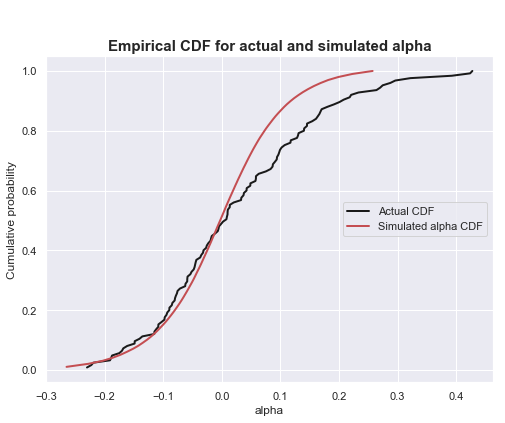

In [109]:
# Generate CDF plot for alphas: 

# compute the ECDF of the samples
qe, pe = ecdf(alphas_sim_prct)
q, p = ecdf(alphas_orig)

# plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(q, p, '-k', lw=2, label='Actual CDF')
ax.plot(qe, pe, '-r', lw=2, label='Simulated alpha CDF')
ax.set_xlabel('alpha')
ax.set_ylabel('Cumulative probability')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nEmpirical CDF for actual and simulated alpha', fontsize=15,fontweight='bold')
plt.show()

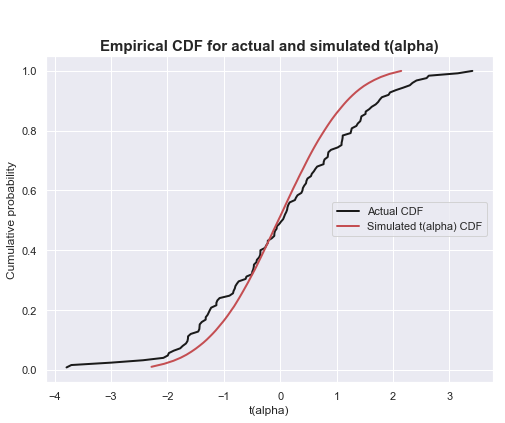

In [110]:
# Generate CDF plot for t(alphas): 
# compute the ECDF of the samples
qe, pe = ecdf(tstats_sim_prct)
qt, pt = ecdf(tstats_orig)

# plot
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(qt, pt, '-k', lw=2, label='Actual CDF')
ax.plot(qe, pe, '-r', lw=2, label='Simulated t(alpha) CDF')
ax.set_xlabel('t(alpha)')
ax.set_ylabel('Cumulative probability')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nEmpirical CDF for actual and simulated t(alpha)', fontsize=15,fontweight='bold')
plt.show()

## 7. Generating Kernel smoothing density estimate plots

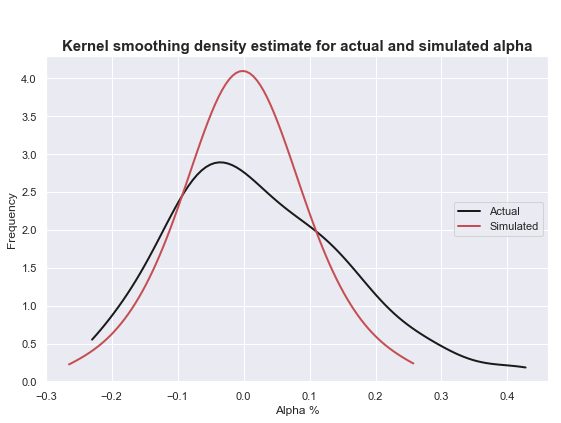

In [111]:
#   Generate Kernel smoothing density estimate plot for alphas: 

kde1 = stats.gaussian_kde(alphas_orig)
kde2 = stats.gaussian_kde(alphas_sim_prct)
x1 = np.linspace(alphas_orig.min(), alphas_orig.max(), 100)
x2 = np.linspace(alphas_sim_prct.min(), alphas_sim_prct.max(), 100)
p1 = kde1(x1)
p2 = kde2(x2)

fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.plot(x1, p1, '-k', lw=2, label='Actual')
ax.plot(x2, p2, '-r', lw=2, label='Simulated')
ax.set_xlabel('Alpha %')
ax.set_ylabel('Frequency')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nKernel smoothing density estimate for actual and simulated alpha', 
          fontsize=15,fontweight='bold')
plt.show()

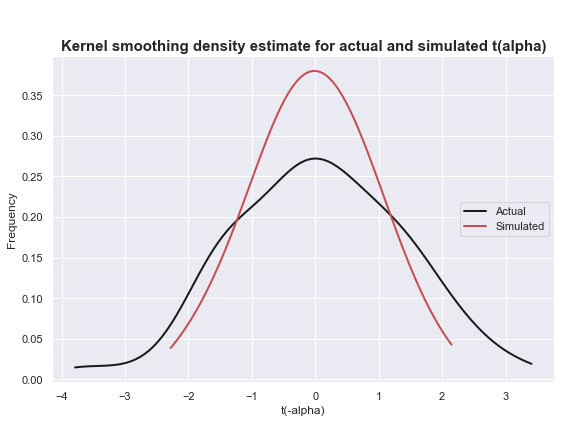

In [112]:
# Generate Kernel smoothing density estimate plot for t-stats of alpha
kde3 = stats.gaussian_kde(tstats_orig)
kde4 = stats.gaussian_kde(tstats_sim_prct)
x3 = np.linspace(tstats_orig.min(), tstats_orig.max(), 100)
x4 = np.linspace(tstats_sim_prct.min(), tstats_sim_prct.max(), 100)
p3 = kde3(x3)
p4 = kde4(x4)

# plot
fig, ax = plt.subplots(1, 1, figsize=(9,6))
ax.plot(x3, p3, '-k', lw=2, label='Actual')
ax.plot(x4, p4, '-r', lw=2, label='Simulated')
ax.set_xlabel('t(-alpha)')
ax.set_ylabel('Frequency')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nKernel smoothing density estimate for actual and simulated t(alpha)', 
          fontsize=15,fontweight='bold')
plt.show()

## 8. Generating histograms

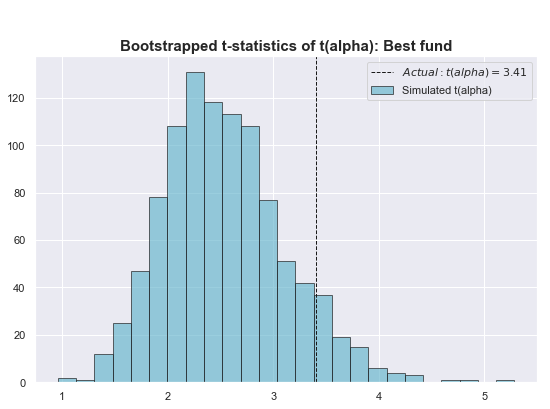

In [113]:
temp_input = -1
temp_t = np.vstack(percentiles_orig_t)[temp_input]

plt.figure(figsize=(9,6))
result = plt.hist(temp_percentiles_sim_t[temp_input,:][~np.isnan(temp_percentiles_sim_t[temp_input,:])],
                  bins=25, color='c', edgecolor='k', alpha=0.65)
plt.axvline(np.vstack(percentiles_orig_t)[temp_input], color='k', linestyle='dashed', linewidth=1)
plt.title('\n\nBootstrapped t-statistics of t(alpha): Best fund', fontsize=15, fontweight='bold')
labels= ['$Actual: t(alpha) = {0:.2f}$'.format(float(temp_t)), 'Simulated t(alpha)']
plt.legend(labels)
plt.show()


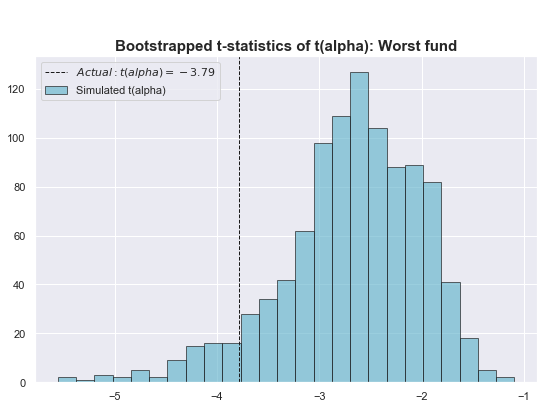

In [114]:
temp_input = 0
temp_t = np.vstack(percentiles_orig_t)[temp_input]

plt.figure(figsize=(9,6))
result = plt.hist(temp_percentiles_sim_t[temp_input,:][~np.isnan(temp_percentiles_sim_t[temp_input,:])], 
                  bins=25, color='c', edgecolor='k', alpha=0.65)
plt.axvline(np.vstack(percentiles_orig_t)[temp_input], color='k', linestyle='dashed', linewidth=1)
plt.title('\n\nBootstrapped t-statistics of t(alpha): Worst fund', fontsize=15, fontweight='bold')
labels= ['$Actual: t(alpha) = {0:.2f}$'.format(float(temp_t)), 'Simulated t(alpha)']
plt.legend(labels)
plt.show()


In [0]:
#Generate histogram of simulated t(alpha)'s for various ranks/percentiles:
#Includes vertical line representing the actual performance of fund at
#equivalent rank/percentile:
#Different index INPUTS used to make histograms from
#'temp_percentiles_sim_t' and vertical lines from 'percentiles_orig_t'
#represent different ranks/percentiles to extract, as specified below:
#input: 1:5 - represents ranks: 101(worst):-1:97
#input: 6:14 - represents percentiles 10:10:90
#input: 15:19 - represents ranks 5:-1:1(best))

#BEST FUND

## 9. Loop through simulation program to inject alpha with different standard deviation assumptions

In [22]:
# Construct simulated series based on "sim_indices"
# tic; % Begin timer
# This script used the simulated index numbers to:
# 1) Pick corresponding numbers from factors and residuals, and
# 2) Construct series of fund returns (potentially including injected alpha)
# 3) Series are "alpha free" if 'std_alpha' below is set to '0'.

# The constructed returns will be the basis for new regressions to
# calculate simulated alphas.

# From before: n = total number of funds
# % h = total number of factors
# % m = total number of time periods
# % s = total number of simulations, s = 1 here refers sim #1

# Check if the value for annual "average" standard deviation is already
# defined. If it is, dont't touch it. If it isn't, define a chosen
# value (usually '0') below. We do this to avoid overriding the std of alpha
# in the loop running through different values of std of alpha

import time

# indices for data
idx = ['Worst','2nd','3rd','4th','5th','10%','20%','30%','40%','50%',
       '60%','70%','80%','90%','5th','4th','3rd','2nd','Best']
idx_series = pd.Series(idx)
t_index = [stdev/4 for stdev in range(0,15)] # testing 15 different standard deviations for simulation

# data to store results
data_cols = ['Actual']
for std in t_index:
    data_cols.append('Sim Avg ({:.2f})'.format(std))
    data_cols.append('%<Act ({:.2f})'.format(std))

data_a = pd.DataFrame([], index=idx, columns=data_cols) # alphas
data_t = pd.DataFrame([], index=idx, columns=data_cols) # t-statistics


# Sort original alphas and t-values in order to extract top/bottom ranked values:
temp_sorted_orig_a =  orig_coeffs.take([0], axis=0).sort_values(by=['Alpha'], axis=1, ascending = [0])
temp_sorted_orig_t = orig_t_stats.take([0], axis=0).sort_values(by=['t(Alpha)'], axis=1, ascending = [0])

# percentiles: alphas and t-stats
percentages = [.10, .20, .30, .40, .50, .60, .70, .80, .90]
percentages1 = [10,20,30,40,50,60,70,80,90]
percentiles_orig_a = [temp_sorted_orig_a.T.tail(5).iloc[::-1],
                      temp_sorted_orig_a.T.quantile(percentages),
                      temp_sorted_orig_a.T.head(5).iloc[::-1]]
data_a['Actual'] = np.vstack(percentiles_orig_a)

percentiles_orig_t = [temp_sorted_orig_t.T.tail(5).iloc[::-1],
                      temp_sorted_orig_t.T.quantile(percentages),
                      temp_sorted_orig_t.T.head(5).iloc[::-1]]
data_t['Actual'] = np.vstack(percentiles_orig_t)


# OTHER PARAMETERS 
# Set minumum number of observations(n) required in simulation for the
# regression to be valid:
sim_cutoff = 15

# Construct matrices of all simulated factor and fund returns:
constructed_X_mat = np.empty((n_obs,n_factors,n_simulations))*np.nan # X_mats for each simulation
constructed_resids = np.empty((n_obs,n_funds,n_simulations))*np.nan  # resids for each simulation
constructed_Y_all = np.empty((n_obs,n_funds,n_simulations))*np.nan   # n_funds fund returns for each sim
sim_indices = np.random.randint(0, n_obs, size=(n_obs,n_simulations))    # randomized simulations

# timing program
start_time = time.time()
for std_i,std in enumerate(t_index):
    loop_start = time.time()
    annual_std_alpha = std
    std_alpha = annual_std_alpha/np.sqrt(12)
    
    #-----------------------------------------------------------------------------------
    # print statements in order to keep track of program
    title = "Standard Deviation {} of {}".format(std_i+1,len(t_index))
    print("-"*len(title))
    print(title)
    print("-"*len(title))
    print("Annual standard deviation: {:.2f}, Standard deviation alpha: {:.2f}"\
          .format(annual_std_alpha, std_alpha))
    #-----------------------------------------------------------------------------------
    
    temp_avg_orig_std_resid = np.nanmean(orig_SE_resid.values)
    temp_std_resid_ratio = np.divide(orig_SE_resid,temp_avg_orig_std_resid)
    
    temp_alpha = std_alpha*np.tile(\
                     np.random.randn(1,n_funds,n_simulations) * np.tile(temp_std_resid_ratio, \
                     (1,1,n_simulations)).reshape((1,n_funds,n_simulations), order='F'),(n_obs,1,1))
    
    orig_betas = orig_coeffs_rank_a.transpose().values[1:4,:]
    constructed_resids = np.empty((n_obs,n_funds,n_simulations))*np.nan
    constructed_Y_all = np.empty((n_obs,n_funds,n_simulations))*np.nan
    for ss in range(n_simulations):
        # randomized simulations of Fama-French risk factors: Mkt-RF, SMB, HML
        constructed_X_mat[:,:,ss] = X_mat.values[:,1:4][sim_indices[:,ss],:]  
        
        # randomized simulations of residuals from Fama-French equations
        constructed_resids[:,:,ss] = orig_resids[sim_indices[:,ss],:]  
        
        #simulated returns based on fund betas, randomized resids and alphas (0?)
        constructed_Y_all[:,:,ss] = temp_alpha[:,:,ss] \
                                   +np.matmul(constructed_X_mat[:,:,ss], orig_betas) \
                                   +constructed_resids[:,:,ss]
    
    #-----------------------------------------------------------------------------------
    print("Simulation X and Y matrices populated! Now regressions...")
    #-----------------------------------------------------------------------------------
    
    # Populate target output vectors to be filled in with loop:
    sim_SE_resid = np.empty((n_factors+1,n_funds,n_simulations))*np.nan
    sim_coeffs = np.empty((n_factors+1,n_funds,n_simulations))*np.nan

    # Calculate number of observations per fund per simulation for future
    # reference:
    n_i_s = (~np.isnan(constructed_Y_all)).sum(0)

    # Calculate the lag selection parameter for the standard Newey-West HAC
    # estimate (Andrews and Monohan, 1992), one number per fund per simulation:
    maxLag_s = np.floor((4*(n_i_s/100)**(2/9))).astype(int)
    
    # Loop through each simulation run:
    for ss in range(n_simulations):
        #Loop through each fund:
        for jj in range(n_funds):
            if n_i_s[jj,ss]>= sim_cutoff:
                xa = sm.add_constant(constructed_X_mat[:,:,ss])
                ya_sample = constructed_Y_all[:,jj,ss]
                maxLag_temp = maxLag_s[jj,ss]

                # linear regression
                lma = ols_s(ya_sample, xa, maxLag_temp)
                sim_SE_resid[:,jj,ss] = lma.bse
                sim_coeffs[:,jj,ss] = lma.params

    sim_t_stats = np.divide(sim_coeffs,sim_SE_resid)
    
    #-----------------------------------------------------------------------------------
    print('Regressions finished! Making percentiles...')
    #-----------------------------------------------------------------------------------

    # sorted simulations by alphas and t-stats
    temp_sort_asc_sim_a = np.sort(sim_coeffs[0,:,:].T, axis=1)
    temp_sort_asc_sim_t = np.sort(sim_t_stats[0,:,:].T, axis=1)
    temp_percentiles_sim_a = np.concatenate((temp_sort_asc_sim_a.T[0:5,:], \
                             np.percentile(sim_coeffs[0,:,:].T, percentages1, axis = 1), \
                             temp_sort_asc_sim_a.T[-5:,:]))
    temp_percentiles_sim_t = np.concatenate((temp_sort_asc_sim_t.T[0:5,:], \
                             np.percentile(sim_t_stats[0,:,:].T, percentages1, axis = 1), \
                             temp_sort_asc_sim_t.T[-5:,:]))
    mean_percentiles_sim_a = np.nanmean(temp_percentiles_sim_a, axis=1)
    mean_percentiles_sim_t = np.nanmean(temp_percentiles_sim_t, axis=1)

    sim_smaller_a = np.sum(temp_percentiles_sim_a < \
                           np.tile(np.vstack(percentiles_orig_a),
                                   (1,n_simulations)), axis=1)/n_simulations*100
    sim_smaller_t = np.sum(temp_percentiles_sim_t < \
                           np.tile(np.vstack(percentiles_orig_t),
                                   (1,n_simulations)), axis=1)/n_simulations*100
    
    #-----------------------------------------------------------------------------------
    print("Populating data tables...")
    #-----------------------------------------------------------------------------------
    
    # Collecting alpha data
    data_a['Sim Avg ({:.2f})'.format(std)] = mean_percentiles_sim_a
    data_a['%<Act ({:.2f})'.format(std)] = sim_smaller_a

    # Collecting t-stat data
    data_t['Sim Avg ({:.2f})'.format(std)] = mean_percentiles_sim_t
    data_t['%<Act ({:.2f})'.format(std)] = sim_smaller_t
    
    #-----------------------------------------------------------------------------------
    print("DONE! ({:.2f} seconds for this iteration)\n".format(time.time()-loop_start))
    #-----------------------------------------------------------------------------------
    
total_time = time.time() - start_time
total_min = int(np.floor(total_time/60))
total_sec = total_time % 60
print("Total time elapsed = {} minutes and {:.2f} seconds.".format(total_min,total_sec))

--------------------------
Standard Deviation 1 of 15
--------------------------
Annual standard deviation: 0.00, Standard deviation alpha: 0.00
Simulation X and Y matrices populated! Now regressions...
Regressions finished! Making percentiles...
Populating data tables...
DONE! (127.94 seconds for this iteration)

--------------------------
Standard Deviation 2 of 15
--------------------------
Annual standard deviation: 0.25, Standard deviation alpha: 0.07
Simulation X and Y matrices populated! Now regressions...
Regressions finished! Making percentiles...
Populating data tables...
DONE! (117.08 seconds for this iteration)

--------------------------
Standard Deviation 3 of 15
--------------------------
Annual standard deviation: 0.50, Standard deviation alpha: 0.14
Simulation X and Y matrices populated! Now regressions...
Regressions finished! Making percentiles...
Populating data tables...
DONE! (116.52 seconds for this iteration)

--------------------------
Standard Deviation 4 of 1

In [70]:
data_a.to_csv('../luck_vs_skill_alpha15.csv')
data_t.to_csv('../luck_vs_skill_tstat15.csv')

In [118]:
data_a.iloc[:,0:11]

,Actual,Sim Avg (0.00),%<Act (0.00),Sim Avg (0.25),%<Act (0.25),Sim Avg (0.50),%<Act (0.50),Sim Avg (0.75),%<Act (0.75),Sim Avg (1.00),%<Act (1.00)
Worst,-0.229878,-0.351381,89.7,-0.430168,99.0,-0.611262,99.9,-0.828656,100.0,-1.045590,100.0
2nd,-0.222565,-0.275564,73.7,-0.337513,95.5,-0.475979,99.9,-0.640906,100.0,-0.829173,100.0
3rd,-0.219048,-0.240082,60.2,-0.295178,88.8,-0.416882,99.8,-0.560457,100.0,-0.720930,100.0
4th,-0.190659,-0.217293,67.0,-0.266688,92.2,-0.375967,99.9,-0.508498,100.0,-0.650546,100.0
5th,-0.188634,-0.200034,57.1,-0.245667,86.1,-0.345483,99.7,-0.468934,100.0,-0.598225,100.0
10%,-0.138338,-0.127884,36.1,-0.156624,67.5,-0.220720,98.0,-0.299076,99.9,-0.382783,100.0
20%,-0.089291,-0.080046,36.7,-0.097123,58.3,-0.137509,92.1,-0.185204,98.6,-0.237416,100.0
30%,-0.058700,-0.049376,36.9,-0.059279,48.9,-0.084097,78.3,-0.112233,92.6,-0.143722,98.0
40%,-0.028486,-0.024250,43.8,-0.029067,49.3,-0.040476,65.6,-0.054506,77.9,-0.068755,84.6
50%,0.008053,-0.001717,63.5,-0.002086,63.7,-0.001632,61.7,-0.002100,61.7,-0.001662,59.9


In [117]:
data_t.iloc[:,0:11]

,Actual,Sim Avg (0.00),%<Act (0.00),Sim Avg (0.25),%<Act (0.25),Sim Avg (0.50),%<Act (0.50),Sim Avg (0.75),%<Act (0.75),Sim Avg (1.00),%<Act (1.00)
Worst,-3.787495,-2.711190,6.7,-3.394377,27.2,-4.822660,87.1,-6.491033,100.0,-8.312802,100.0
2nd,-3.702615,-2.335346,1.6,-2.883419,9.2,-4.075458,68.4,-5.533909,99.6,-7.083677,100.0
3rd,-2.998788,-2.126821,5.5,-2.613041,22.2,-3.696745,88.3,-5.031780,100.0,-6.419760,100.0
4th,-2.432716,-1.981262,15.6,-2.429271,45.6,-3.428987,96.7,-4.667112,100.0,-5.936049,100.0
5th,-2.070504,-1.864746,30.3,-2.280768,66.2,-3.230702,98.9,-4.381798,100.0,-5.584068,100.0
10%,-1.634098,-1.303296,18.2,-1.588539,41.9,-2.260801,93.6,-3.056295,99.9,-3.881512,100.0
20%,-1.227415,-0.861290,15.4,-1.050372,28.7,-1.482026,74.2,-1.994330,96.1,-2.555124,99.9
30%,-0.609360,-0.549581,41.3,-0.660080,54.6,-0.931418,81.7,-1.247365,93.8,-1.596778,98.2
40%,-0.300439,-0.276018,46.0,-0.331992,53.3,-0.458540,67.4,-0.614768,78.5,-0.780941,85.4
50%,0.053437,-0.021714,58.5,-0.022050,59.7,-0.018713,56.8,-0.022062,58.4,-0.021329,56.2
